<a href="https://colab.research.google.com/github/visvikbharti/deep_learning/blob/master/EIJ_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DNA Sequence Classification using LSTM:**
 
 GOAL: To classify the DNA sequence each of length 60 into either of three categories:
 
      1. EI - Exon-Intron junction sequences

      2. IE - Intron-Exon Junction sequences

      3. N -  Neither


**Splice dataset :**

I have taken Splice dataset from UCI Machine Learning Repository.

In the splice dataset I have 3190 DNA sequences each of length 60 which consist of the following: {A, G, C, T, N, D, S, R}. 

Character : Meaning

D:  A or G or T

N:  A or G or C or T

S:  C or G

R:  A or G

And the corresponding classes are of the following : {EI, IE, N}


Importing all dependencies

In [18]:
import tensorflow as tf
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import os

# For LSTM Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model, Sequential

from sklearn.model_selection import train_test_split
print(tf.test.is_built_with_cuda())

True


**Plot Function**  : To plot the Accuracy and loss graph.

In [20]:
#plot function
def plot(args, labels, x_label: str = None, y_label: str = None, tag: str = None, path: str = '.', show=True):
    for arg, label in zip(args, labels):
        epochs = [i+1 for i in range(len(arg))]
        plt.plot(epochs, arg, label=label)

    if y_label:
        plt.ylabel(y_label)
    if x_label:
        plt.xlabel(x_label)

    if tag:
        plt.title(tag)

    plt.legend()
    if path:
        plt.savefig(path)
    if show:
      plt.show()
    else:
      plt.clf()

**Loading Splice dataset:**  Function for loading the "splice.data" from "training_data: folder.

In [21]:
#function for loading dataset
def load_train_data():
  data = None
  with open('training_data/splice.data') as f:
    data = f.readlines()

  data_tuple = [(d.split(',')[0], d.split(',')[-1].strip()) for d in data]
  x = np.array([val[1] for val in data_tuple])
  y = np.array([val[0] for val in data_tuple])
  return x, y

In [22]:
#Loading the data
x, y = load_train_data()

**One hot encoding of the training data.**   


In [23]:
# creating one hot encoded values for each class in y
classes = list(set(y))
encoded_y = tf.one_hot(range(len(classes)), depth=len(classes))

# creating one hot encoded values for each symbol in x
primary_symbols = ['A', 'G', 'C', 'T']
derived_symbols = ['D', 'S', 'R', 'N']
symbols = primary_symbols + derived_symbols

## symbol representing equal probability of primary symbols occurence
symbol_occ_map = {
    'D': ['A', 'G', 'T'],
    'S': ['C', 'G'],
    'R': ['A', 'G'],
    'N': ['A', 'G', 'C', 'T']
}

encoded_sym = tf.one_hot(range(len(primary_symbols)), depth=len(primary_symbols))

symbol_map = {sym:encoded_sym[idx] for idx, sym in enumerate(primary_symbols)}

for sym in derived_symbols:
  symbol_map[sym] = np.sum([symbol_map[p_sym] for p_sym in symbol_occ_map[sym]], axis=0)

for sym in symbols:
    print(f"{sym} -> {symbol_map[sym]}")

# mapping class/symbol names to their hot encoded values
class_map = {class_:encoded_y[idx] for idx, class_ in enumerate(classes)}


print(f"symbols: {symbols}")
print(f"Encoded symbol: {encoded_sym}")

print(f"classes: {classes}")
print(f"Encoded classes: {encoded_y}")

A -> [1. 0. 0. 0.]
G -> [0. 1. 0. 0.]
C -> [0. 0. 1. 0.]
T -> [0. 0. 0. 1.]
D -> [1. 1. 0. 1.]
S -> [0. 1. 1. 0.]
R -> [1. 1. 0. 0.]
N -> [1. 1. 1. 1.]
symbols: ['A', 'G', 'C', 'T', 'D', 'S', 'R', 'N']
Encoded symbol: [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
classes: ['IE', 'N', 'EI']
Encoded classes: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


Function for decoding the one hot encoded data:

In [25]:
# to get symbol representation of sequence from one hot encoded values
to_symbol = lambda hot_encoded: "".join([symbols[idx] for idx in tf.argmax(hot_encoded, axis=1)])


def test_same(sample_val):
  sample_val = x[1293]
  sample_encoded = [symbol_map[char] for char in sample_val]
  reversed = to_symbol(sample_encoded)
  return sample_val == reversed

**Making numpy array of input and output data:**

In [26]:
X = np.array([[symbol_map[char] for char in sequence] for sequence in x])
Y = np.array([class_map[class_] for class_ in y])
print(f"X : {X.shape}")
print(f"Y : {Y.shape}")

X : (3190, 60, 4)
Y : (3190, 3)


**Splitting dataset:**

Splitting data into test and train set using scikit learn functions.

In [27]:
# splitting data into train, test
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=21)
print(f"Train X : {train_x.shape}")
print(f"Test X : {test_x.shape}")
print(f"Train Y : {train_y.shape}")
print(f"Test Y : {test_y.shape}")

Train X : (2552, 60, 4)
Test X : (638, 60, 4)
Train Y : (2552, 3)
Test Y : (638, 3)


**LSTM model:**

creating LSTM model using TensorFlow.Keras Sequential API.

In [28]:
# LSTM cell
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model, Sequential


batch_size = 32
time_steps = 60
features = 4
input_features = 4
output_features = 3

model = Sequential()
model.add(LSTM(100, input_shape=(time_steps, input_features)))
model.add(Dense(3, activation='sigmoid'))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics= ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               42000     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 42,303
Trainable params: 42,303
Non-trainable params: 0
_________________________________________________________________


**Model Training:**


In [29]:
history = model.fit(x=train_x, y=train_y, batch_size=batch_size, validation_data=(test_x,test_y), epochs=100, verbose='auto')
print(history.history.keys())

Epoch 1/100
80/80 [==============================] - 5s 45ms/step - loss: 0.9916 - accuracy: 0.5270 - val_loss: 0.8921 - val_accuracy: 0.5956
Epoch 2/100
80/80 [==============================] - 3s 39ms/step - loss: 0.8140 - accuracy: 0.6121 - val_loss: 0.7055 - val_accuracy: 0.6740
Epoch 3/100
80/80 [==============================] - 3s 39ms/step - loss: 0.7307 - accuracy: 0.6697 - val_loss: 0.7071 - val_accuracy: 0.6850
Epoch 4/100
80/80 [==============================] - 3s 38ms/step - loss: 0.7157 - accuracy: 0.6850 - val_loss: 0.6661 - val_accuracy: 0.7116
Epoch 5/100
80/80 [==============================] - 3s 41ms/step - loss: 0.6744 - accuracy: 0.7002 - val_loss: 0.6374 - val_accuracy: 0.7179
Epoch 6/100
80/80 [==============================] - 3s 39ms/step - loss: 0.6471 - accuracy: 0.7183 - val_loss: 0.6482 - val_accuracy: 0.6928
Epoch 7/100
80/80 [==============================] - 3s 39ms/step - loss: 0.6252 - accuracy: 0.7312 - val_loss: 0.6257 - val_accuracy: 0.7429
Epoch 

**Getting the keys of hostory.hostory:**

These keys are helpful while plotting the accuracy or loss graph.

In [30]:
print(history.history.keys())
data = history.history

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


**Plotting the Accuracy against epochs:**

Final Train Acc = 0.9976488947868347
Final Test Acc = 0.9341692924499512


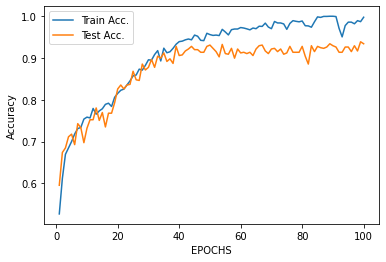

In [31]:
print(f"Final Train Acc = {data['accuracy'][-1]}")
print(f"Final Test Acc = {data['val_accuracy'][-1]}")
plot([data['accuracy'], data['val_accuracy']], ['Train Acc.', 'Test Acc.'], x_label='EPOCHS', y_label='Accuracy')

**Plotting the Loss against epochs:**

Here I hve used the "categorical crossentropy" loss function.

Final Train Loss = 0.009991929866373539
Final Test Loss = 0.34166479110717773


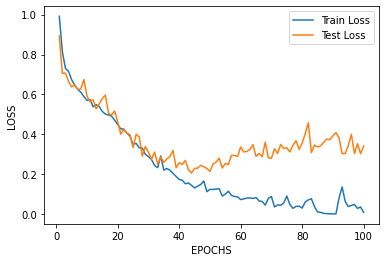

In [32]:
print(f"Final Train Loss = {data['loss'][-1]}")
print(f"Final Test Loss = {data['val_loss'][-1]}")
plot([data['loss'], data['val_loss']], ['Train Loss', 'Test Loss'], x_label='EPOCHS', y_label='LOSS')

**Conclusion of the LSTM model training os Splice data:**

Here we can see that the accuracy of the training set is about 99.3%, while the accuracy of the test set is about 93.14%.

This difference can be due to various reasons but the dominating reason could be the "overfitting" of the model.


I got inspiration for the model training on splice data from the following paper, where they have used Convolutional Neural Network and some other encoding to train the model.

Link of the paper: https://www.researchgate.net/publication/301703031_DNA_Sequence_Classification_by_Convolutional_Neural_Network

**Their Accuracy : 92.6%**

**My Accuracy : 93.1%** (On test set) and

**My accuracy : 99.33%** (on training set).